In [1]:
%cd "G:\My Drive\hdsp\proyectos\seismic_craft\SeismicEnhancement\"

G:\My Drive\hdsp\proyectos\seismic_craft\SeismicEnhancement


In [2]:
import os 
import torch 

from dataclasses import dataclass
from torchvision.utils import make_grid


from libs.utils import get_default_device
from libs.dataloader import get_dataloader, inverse_transform


from libs.diffusion.config import BaseConfig, TrainingConfig, ModelConfig

torch.Size([16, 1, 128, 128])


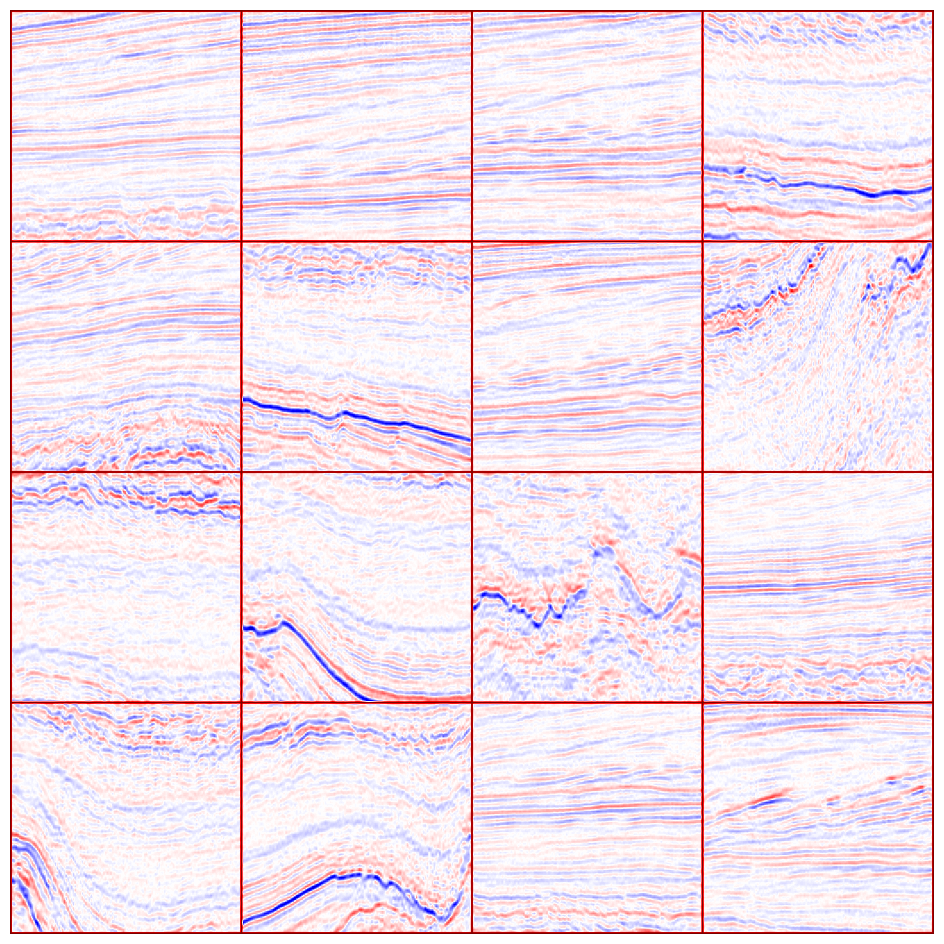

In [3]:
import matplotlib.pyplot as plt

loader = get_dataloader(
    dataset_name=BaseConfig.DATASET,
    batch_size=16,
    device='cpu',
)

plt.figure(figsize=(12, 12), facecolor='white')

for b_image in loader:
    print(b_image.shape)
    b_image = inverse_transform(b_image).cpu()
    grid_img = make_grid(b_image / 255.0, nrow=4, padding=True, pad_value=1, normalize=False)
    plt.imshow(grid_img.permute(1, 2, 0)[..., 0], cmap="seismic", vmin=0, vmax=1)
    plt.axis("off")
    break

In [4]:
from libs.variational import VAE

model_params = dict(
    in_channels=1,
    latent_dim=128
)

model = VAE(**model_params)
model.to(BaseConfig.DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=TrainingConfig.LR)

dataloader = get_dataloader(
    dataset_name  = BaseConfig.DATASET,
    batch_size    = TrainingConfig.BATCH_SIZE,
    device        = BaseConfig.DEVICE,
    pre_load_data = True,
)

# kld_weight = 0.00025
kld_weight = 0.00001

In [5]:
from tqdm import tqdm
from torchmetrics import MeanMetric

EPOCHS = TrainingConfig.NUM_EPOCHS


def train_one_epoch(model, loader, optimizer, epoch=0):

    model.train()

    loss_record = MeanMetric()

    with tqdm(total=len(loader), dynamic_ncols=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch}/{EPOCHS}")

        for batch in loader:

            real_img = batch.to(BaseConfig.DEVICE)
            tq.update(1)
            

            results = model(real_img)
            
            train_loss = model.loss_function(*results, M_N=kld_weight)
            loss = train_loss['loss']

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_value = loss.detach().item()
            loss_record.update(loss_value)

            tq.set_postfix_str(s=f"Loss: {loss_value:.4f}")

        mean_loss = loss_record.compute().item()    
        tq.set_postfix_str(s=f"Epoch Loss: {mean_loss:.4f}")

In [6]:
import matplotlib.pyplot as plt


def plot(output):
    plt.figure(figsize=(16, 16))

    b_image = inverse_transform(output.detach()).cpu()
    # b_image = output.detach().cpu()
    grid_img = make_grid(b_image, nrow=8, padding=True, pad_value=128, normalize=False)
    plt.imshow(grid_img.permute(1, 2, 0)[..., 0], cmap="seismic")
    plt.axis("off")
    plt.show()



for epoch in range(EPOCHS):

    train_one_epoch(model, dataloader, optimizer, epoch=epoch)

    model.eval()
    
    with torch.no_grad():
        output = model.sample(16, current_device=BaseConfig.DEVICE)
        plot(output)
    

Train :: Epoch: 0/10:  21%|██        | 131/633 [00:34<02:12,  3.80it/s, Loss: 0.0076]


KeyboardInterrupt: 